### 0.1 Import Package

In [1]:
import os
import re
import sys
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import utils
from torchvision import datasets, models, transforms
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0")

PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121


### 0.2. Directory Setting

In [2]:
# from model.models import Conv4
from model.pretrained_models import get_pretrain_model
from dataset_dir.datasets import datasetload

In [3]:
MODEL_DIR = "./model/weight/"
LOG_DIR = "./results/log/"

**Specific model setting**: 특정한 모델을 확인하기 위해

In [4]:
RECURSIVE = False

conf = dict(
    epoch=100,
    lr=0.001,
    stepsize=50,
    gamma=0.1,
    model="alexnet",
    dataset="cifar10",
    pretrain=False,
    mode="cus",
    freeze="01011"
)
setting = "epoch"+str(conf['epoch'])+"_lr"+str(conf['lr'])

if conf["pretrain"] :
    name = "pretrain/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
else :
    if str(conf["mode"]) == "cus":
        setting += "_freeze"+str(conf['freeze'])+"111"
        name = "custom/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
    else :
        name = "optimal/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
model_path = MODEL_DIR + name +".pt"
log_path = LOG_DIR +  name


print(model_path)
print(log_path)

./model/weight/custom/alexnet/cifar10_epoch100_lr0.001_freeze01011111.pt
./results/log/custom/alexnet/cifar10_epoch100_lr0.001_freeze01011111


**Entire model setting**: directory에 저장되어있는 전체 모델을 확인하기 위해

In [5]:
RECURSIVE = True

MODEL_DIR += "custom/alexnet/"
LOG_DIR += "custom/alexnet/"


weight_files = [os.path.join(MODEL_DIR, file) for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
log_files = [os.path.join(LOG_DIR, file) for file in os.listdir(LOG_DIR)]

print(len(weight_files))
print(weight_files[0])
print(len(log_files))
print(log_files[0])

26
./model/weight/custom/alexnet/cifar100_epoch100_lr0.001_freeze01011111.pt
26
./results/log/custom/alexnet/cifar100_epoch100_lr0.001_freeze01011111


In [6]:
# for prototype
def name_parser(path):
    """object: 주어진 경로로부터 모델의 특징을 추출 
    input: path (log or weight)
    ouput: mode <- str, model <- str, dataset <- str, freeze <- str"""
    parts = path.split("/")
    mode = parts[3]
    model = parts[4]
    sub_parts = parts[5].split("_")
    dataset = sub_parts[0]
    freeze = sub_parts[3].split(".")[0]
    freeze = ''.join(re.findall(r'\d+', freeze))
    return mode, model, dataset, freeze

# EXAMPLE
mode, model, dataset, freeze = name_parser(weight_files[0])
print(mode, model, dataset, freeze)

custom alexnet cifar100 01011111


In [7]:
SAVE = False

# 1. Architecture
특정 데이터셋, 모델의 구조를 확인하기 위한 코드. RECURSIVE하게 모든 weight파일에 대해서 동작하지 않습니다.

In [8]:
trainloader, validloader, testloader, num_class = datasetload(conf['dataset'])
model = get_pretrain_model(conf['model'], num_class)
model_state = torch.load(model_path)
model.load_state_dict(model_state)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

### 1.1 Model Architecture

In [9]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [11]:
layer_name_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10']
model_info = dict(
    conv1=0,
    conv2=3,
    conv3=6,
    conv4=8,
    conv5=10
)

def get_alias(layer_name, model_info, model="alexnet"):
    if model == "alexnet":
        idx = int(layer_name.split(".")[1])
        key_list = [key for key, value in model_info.items() if value == idx]
        return key_list[0]
    else:
        return -1

print(get_alias(layer_name_list[0], model_info))

conv1


### 1.2 Dataset Property

In [12]:
print(num_class)
print(len(trainloader.dataset))
print(len(testloader.dataset))

10
40000
10000


In [13]:
# from utils.visualize_tool import from_tensor_to_img_plot

def visualize_tensor(tensor, isnomalized=True):
    numpy = tensor.numpy().transpose(1, 2, 0)
    if isnomalized :
        numpy = (numpy - numpy.min()) / (numpy.max() - numpy.min())
    plt.imshow(numpy)
    plt.show()

torch.Size([3, 224, 224])


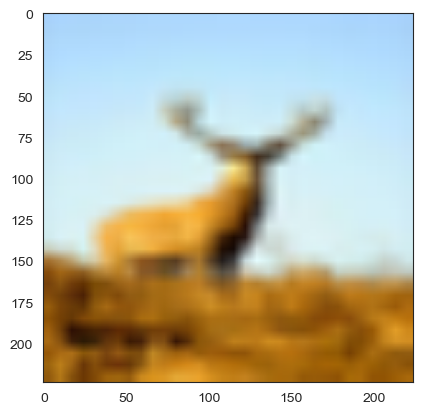

In [15]:
image = trainloader.dataset[1][0]
print(image.shape)

sns.set_style("white")
visualize_tensor(image)

### 1.3 Train Log Print

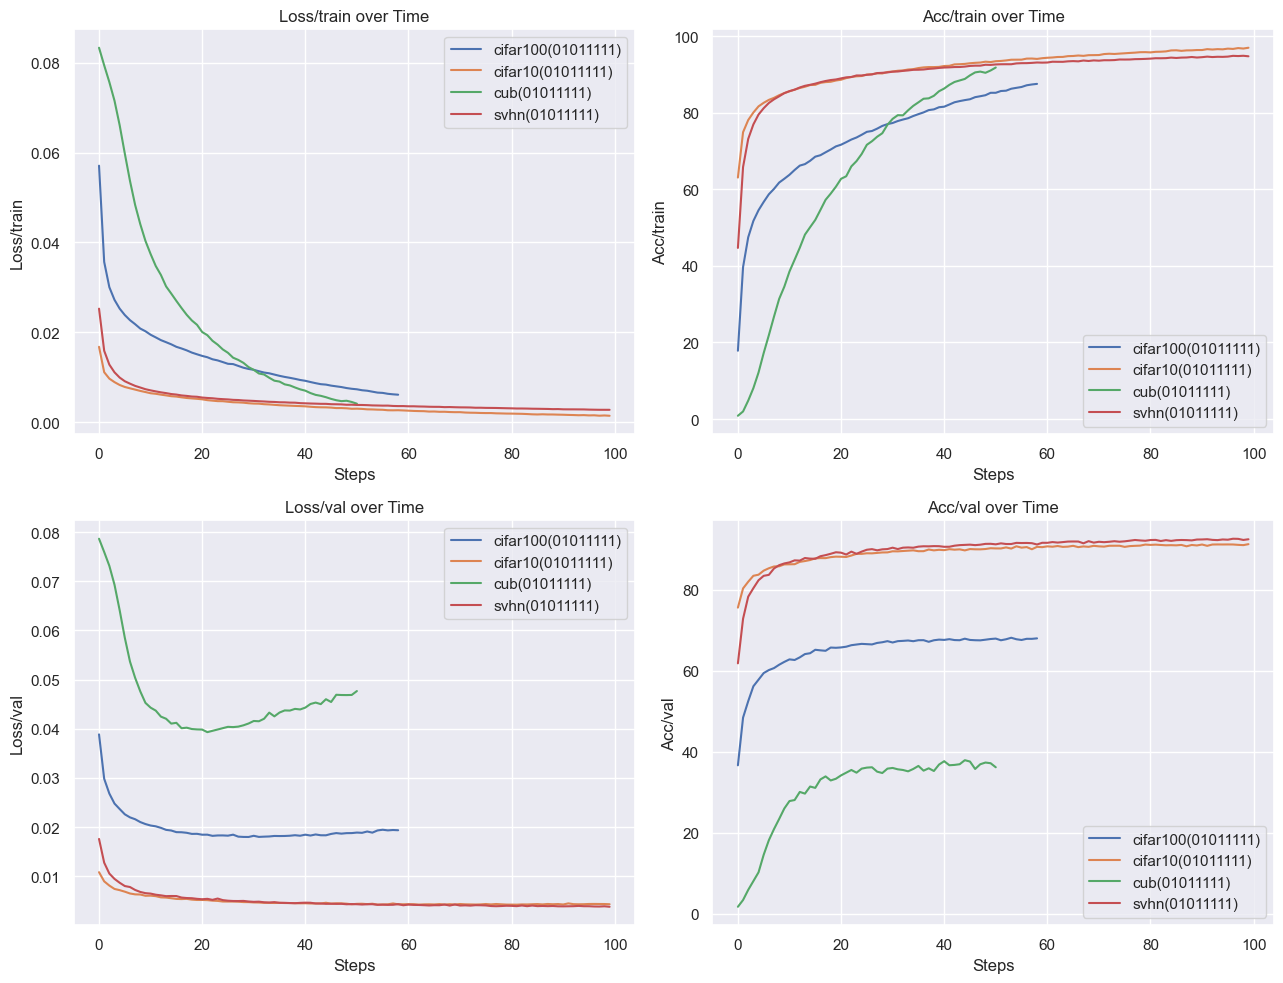

In [61]:
def draw_log(path, isSave=False, overlap=True):
    mode, model, dataset, freeze = name_parser(path)
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    if 'scalars' in event_acc.Tags():
        scalar_tags = event_acc.Tags()['scalars']

        if not overlap :
            plt.figure(figsize=(13, 10))
            sns.set()

        for i, tag in enumerate(scalar_tags):
            values = event_acc.Scalars(tag)
            steps = [v.step for v in values]
            data = [v.value for v in values]
            
            df = pd.DataFrame({'Step': steps, tag: data})

            plt.subplot(2, 2, i + 1)
            sns.lineplot(x='Step', y=tag, data=df, label=dataset+"("+freeze+")" )
            plt.xlabel('Steps')
            plt.ylabel(tag)
            plt.title(f'{tag} over Time')
            
        plt.tight_layout()
        if not overlap :
            plt.show()

if not RECURSIVE :
    draw_log(log_path, SAVE)

else :
    plt.figure(figsize=(13, 10))
    sns.set()
    for log_path in log_files :
        draw_log(log_path, SAVE)
    plt.show()

# 2. Visualization

### 2.1. cnn Filter visualization
`visualize_filters` : 모델을 이루는 각각의 convolution 필터의 가중치를 시각화 합니다. (constraint: 1st channel)

In [16]:
# from utils.visualize_tool import visualize_filters

def plot_filters(tensor, layer_name, ncols=32 , nchannel=5):
    n, _, _, _ = tensor.shape
    nrows = n // ncols + (1 if n % ncols else 0)

    for c in range(nchannel):
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
        for i in range(n):
            ax = axes[i // ncols, i % ncols]
            kernel = tensor[i, c, :, :] if n > 1 else tensor[i, :, :]
            ax.imshow(kernel, cmap='viridis')
            ax.axis('off')
        alias = get_alias(layer_name, model_info)
        plt.suptitle('Layer: '+alias+" (# channel: "+str(c)+")")
        plt.show()


def get_weights(model, layer_name):
    flag = False
    for name, layer in model.named_modules():
        if name == layer_name:
            flag = True
            weights = layer.weight.data.clone()
            break
    if not flag :
        print(f'Undefined Layer.')
        return -1
    return weights


def visualize_filters(model, layer_name, ncols=32, nchannel=5, showAll=False):
    weights = get_weights(model, layer_name)
    print(weights.shape)
    n, c, w, h = weights.shape
    if not showAll:
        c = min(c, nchannel)
    plot_filters(weights, layer_name, ncols, c)

In [17]:
layer_names = [name for name, _ in model.named_modules()]
print(layer_names)

['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


torch.Size([64, 3, 11, 11])


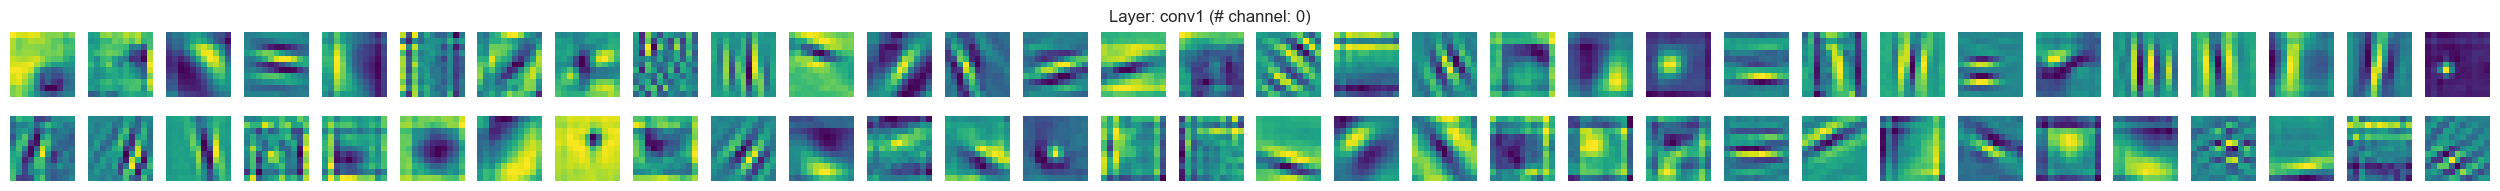

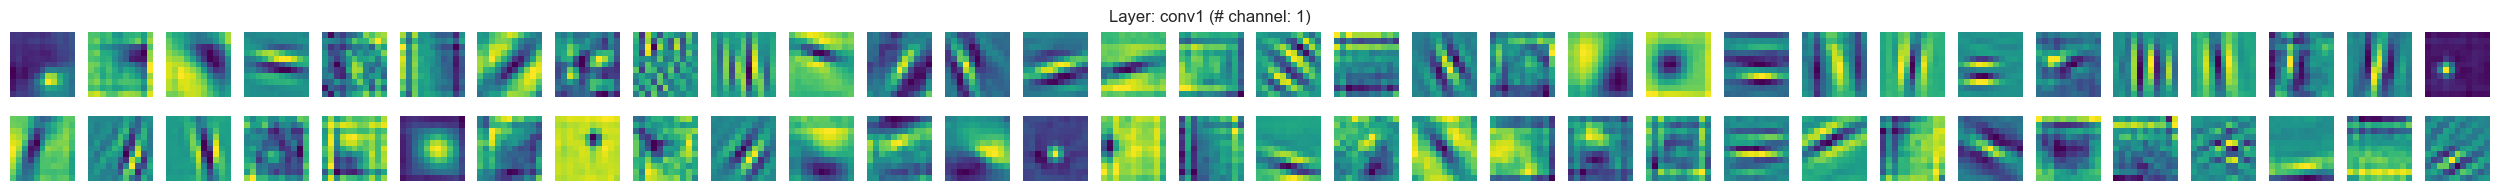

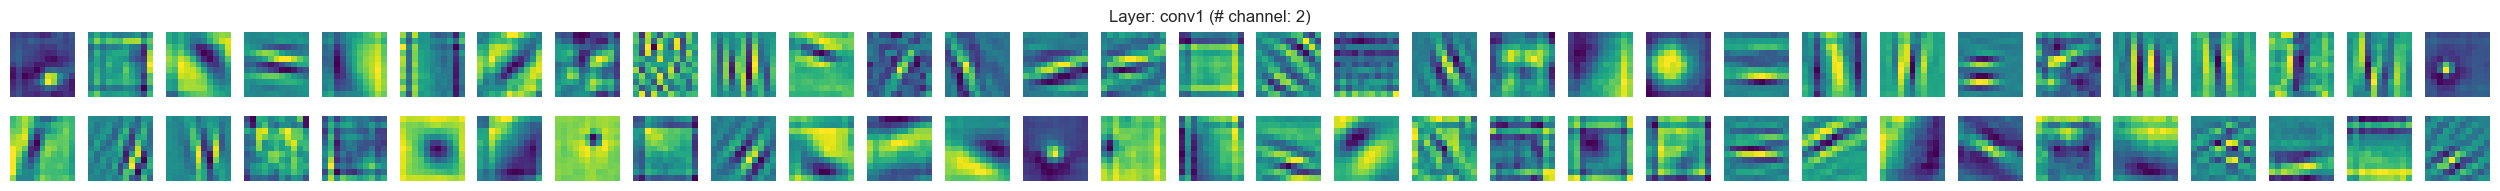

In [18]:
layer_name = "features.0"
visualize_filters(model, layer_name, ncols=32, nchannel=5, showAll=False)

In [ ]:
""" RECURSIVE : Running This!!! """
layer_name_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10']

for name in layer_name_list :
    visualize_filters(model, layer_name, ncols=32, nchannel=5, showAll=False)

### 2.2. Feature map Visualize
`visualize_feature_map` : 특정 입력 이미지에 대해 모델의 각 레이어를 통과했을 때 feature_map을 시각화 합니다. (constraint: 1st feature map)

In [25]:
# 

### for module architecture DNN
# def hook_fn(module, output):
#    module.output = output

# def addHook(model, hook):
#    for layer in model.children():
#        if len(list(layer.children())) > 0:
#            addHook(layer, hook)
#        else:
#            layer.register_forward_hook(hook)

#def get_features(model, output_list):
#    for layer in model.children():
#        if len(list(layer.children())) > 0:
#            get_features(layer, output_list)
#        elif type(layer) == nn.ParameterList:
#            return
#        else:
#            output = layer.output
#            output_list.append(output)

torch.Size([192, 27, 27])


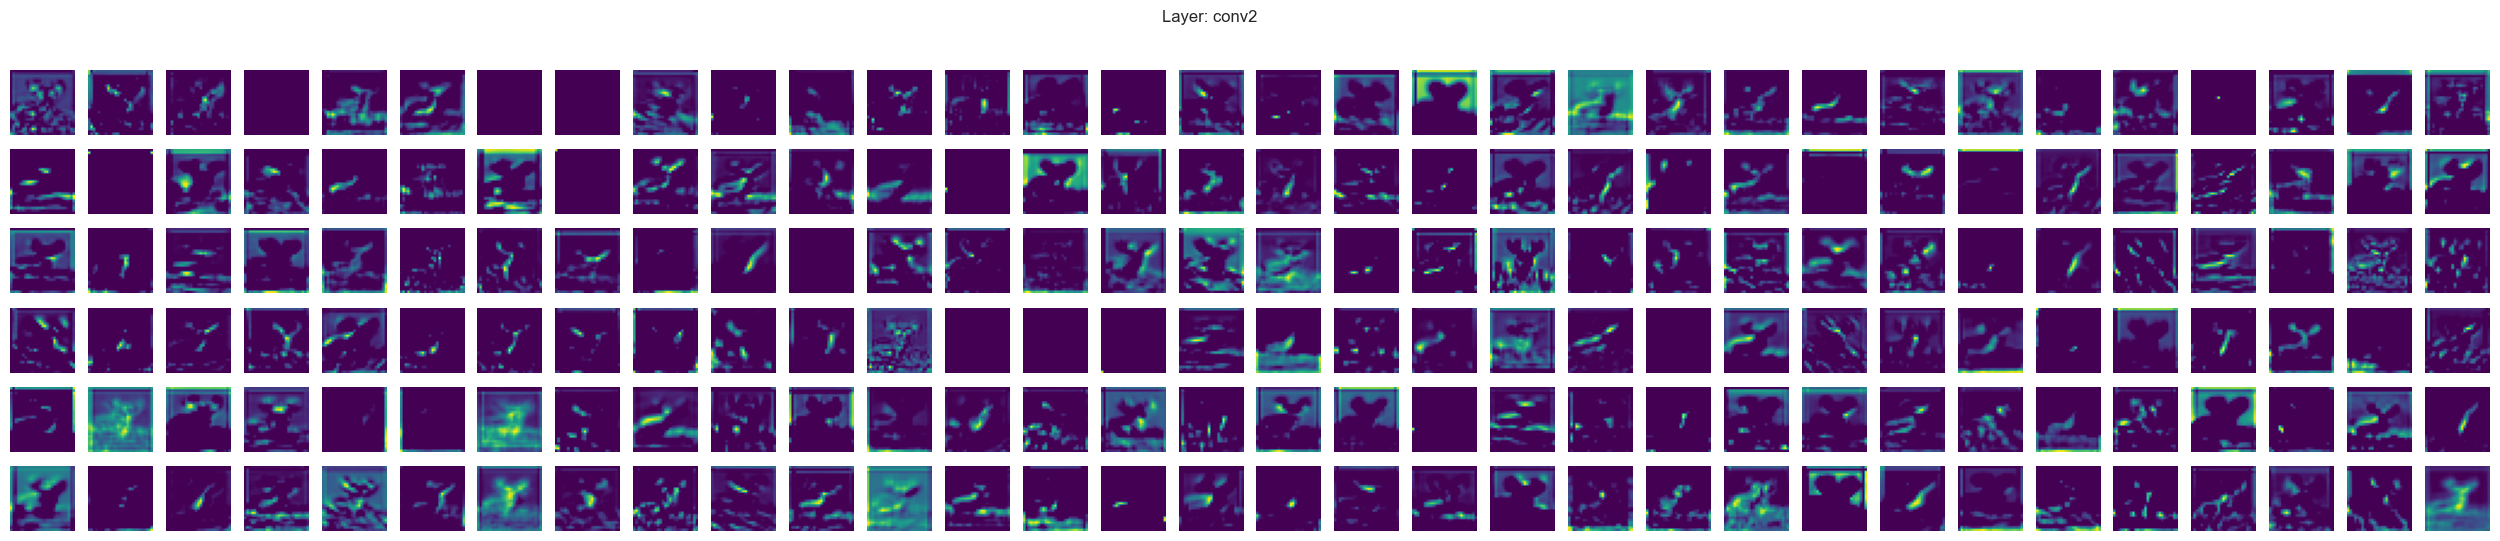

In [29]:
# from utils.visualize_tool import visualize_feature_map

layer_name = 'conv2'
input_image = torch.unsqueeze(image, 0)

activation = {}

def get_feature_map(model, input, layer_name, idx):
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.eval()
    model.features[idx].register_forward_hook(get_activation(layer_name))
    output = model(input)
    act = activation[layer_name].squeeze()
    return act

def visualize_feature_map(model, input, layer_name, idx, ncols=32):
    act = get_feature_map(model, input, layer_name, idx)
    print(act.shape)
    nrows = max(act.size(0) // ncols, 1) 
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    for i in range(act.size(0)):
        ax = axes[i // ncols, i % ncols]
        kernel = act[i]
        ax.imshow(kernel, cmap='viridis')
        ax.axis('off')
    plt.suptitle('Layer: '+layer_name)
    plt.show()

visualize_feature_map(model, input_image, layer_name, model_info[layer_name])

In [ ]:
""" RECURSIVE : Running This!!! """
model_info = dict(
    conv1=0,
    conv2=3,
    conv3=6,
    conv4=8,
    conv5=10
)

input_image = torch.unsqueeze(image, 0)

for layer_name in model_info:
    activation = {}
    visualize_feature_map(model, input_image, layer_name, model_info[layer_name])

### 2.3. weight distribution (each layer)
`weight_distribution_visualize` : 모델을 이루는 각각의 레이어의 가중치 분포를 시각화 합니다. 

In [ ]:
# from visualize_tool import weight_distribution_visualize

def weight_distribution_visualize(model):
    means, variances, weight_df = get_numerical_weight(model)
    
    plt.figure(figsize=(10, 5))
    plt.plot(means, label='Mean')
    plt.plot(variances, label='Variance')
    plt.xlabel('Kernel Index')
    plt.ylabel('Value')
    plt.title('Kernel Weights Statistics (Mean and Variance)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Layer', y='Weights', data=weight_df)
    plt.xlabel('Convolution Layer Number')
    plt.ylabel('Weights')
    plt.title('Weight Distribution in Convolutional Layers')
    plt.show()

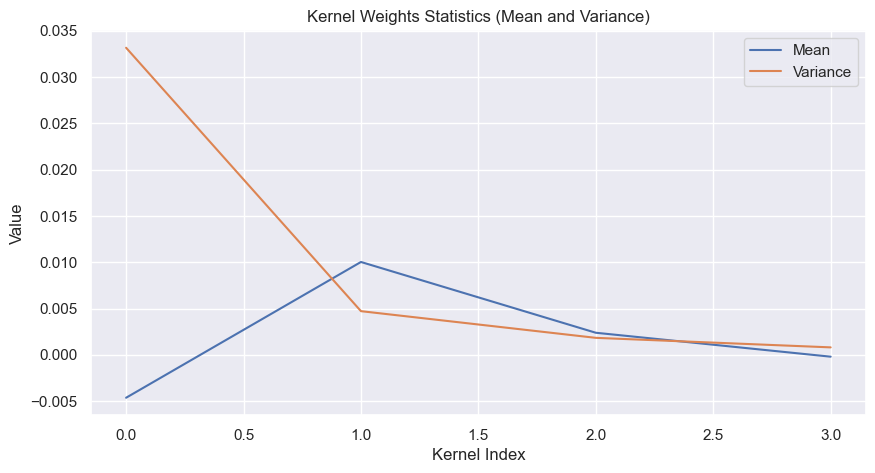

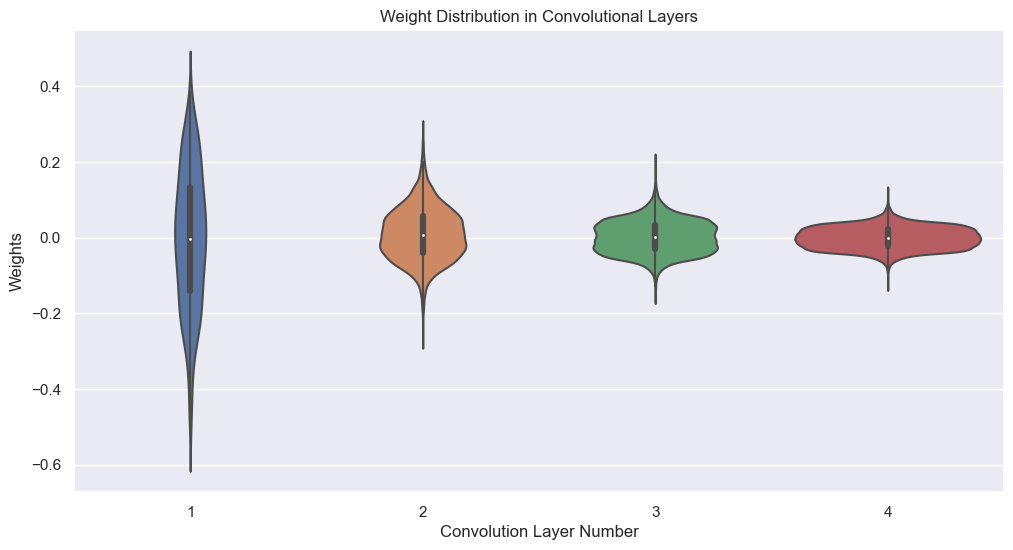

In [ ]:
weight_distribution_visualize(model)

### 2.4. Error plot (each layer)
``: 모델의 각 레이어별 에러 분포를 시각화합니다.

### 2.5. Dataset Distribution
``: 모델이 판단하는 CLASS와 실제 정답 CLASS의 분포를 비교합니다.

### 2.6. Grad CAM
``: 모델이 이미지를 분류할 떄, 어떤 부분에 집중하여 판단하는지 표현합니다.

# 3. Comparison

### 3.1. Train Accuracy
- ``: 각 데이터셋 마다 layer freezing에 따른 train accuracy를 비교합니다.
- ``: 각 layer freezing마다 데이터셋에 따른 train accuracy를 비교합니다.

### 3.2. Test Accuracy
- ``: 각 데이터셋 마다 layer freezing에 따른 test accuracy를 비교합니다.
- ``: 각 layer freezing마다 데이터셋에 따른 test accuracy를 비교합니다.